# Three Sided Market Model

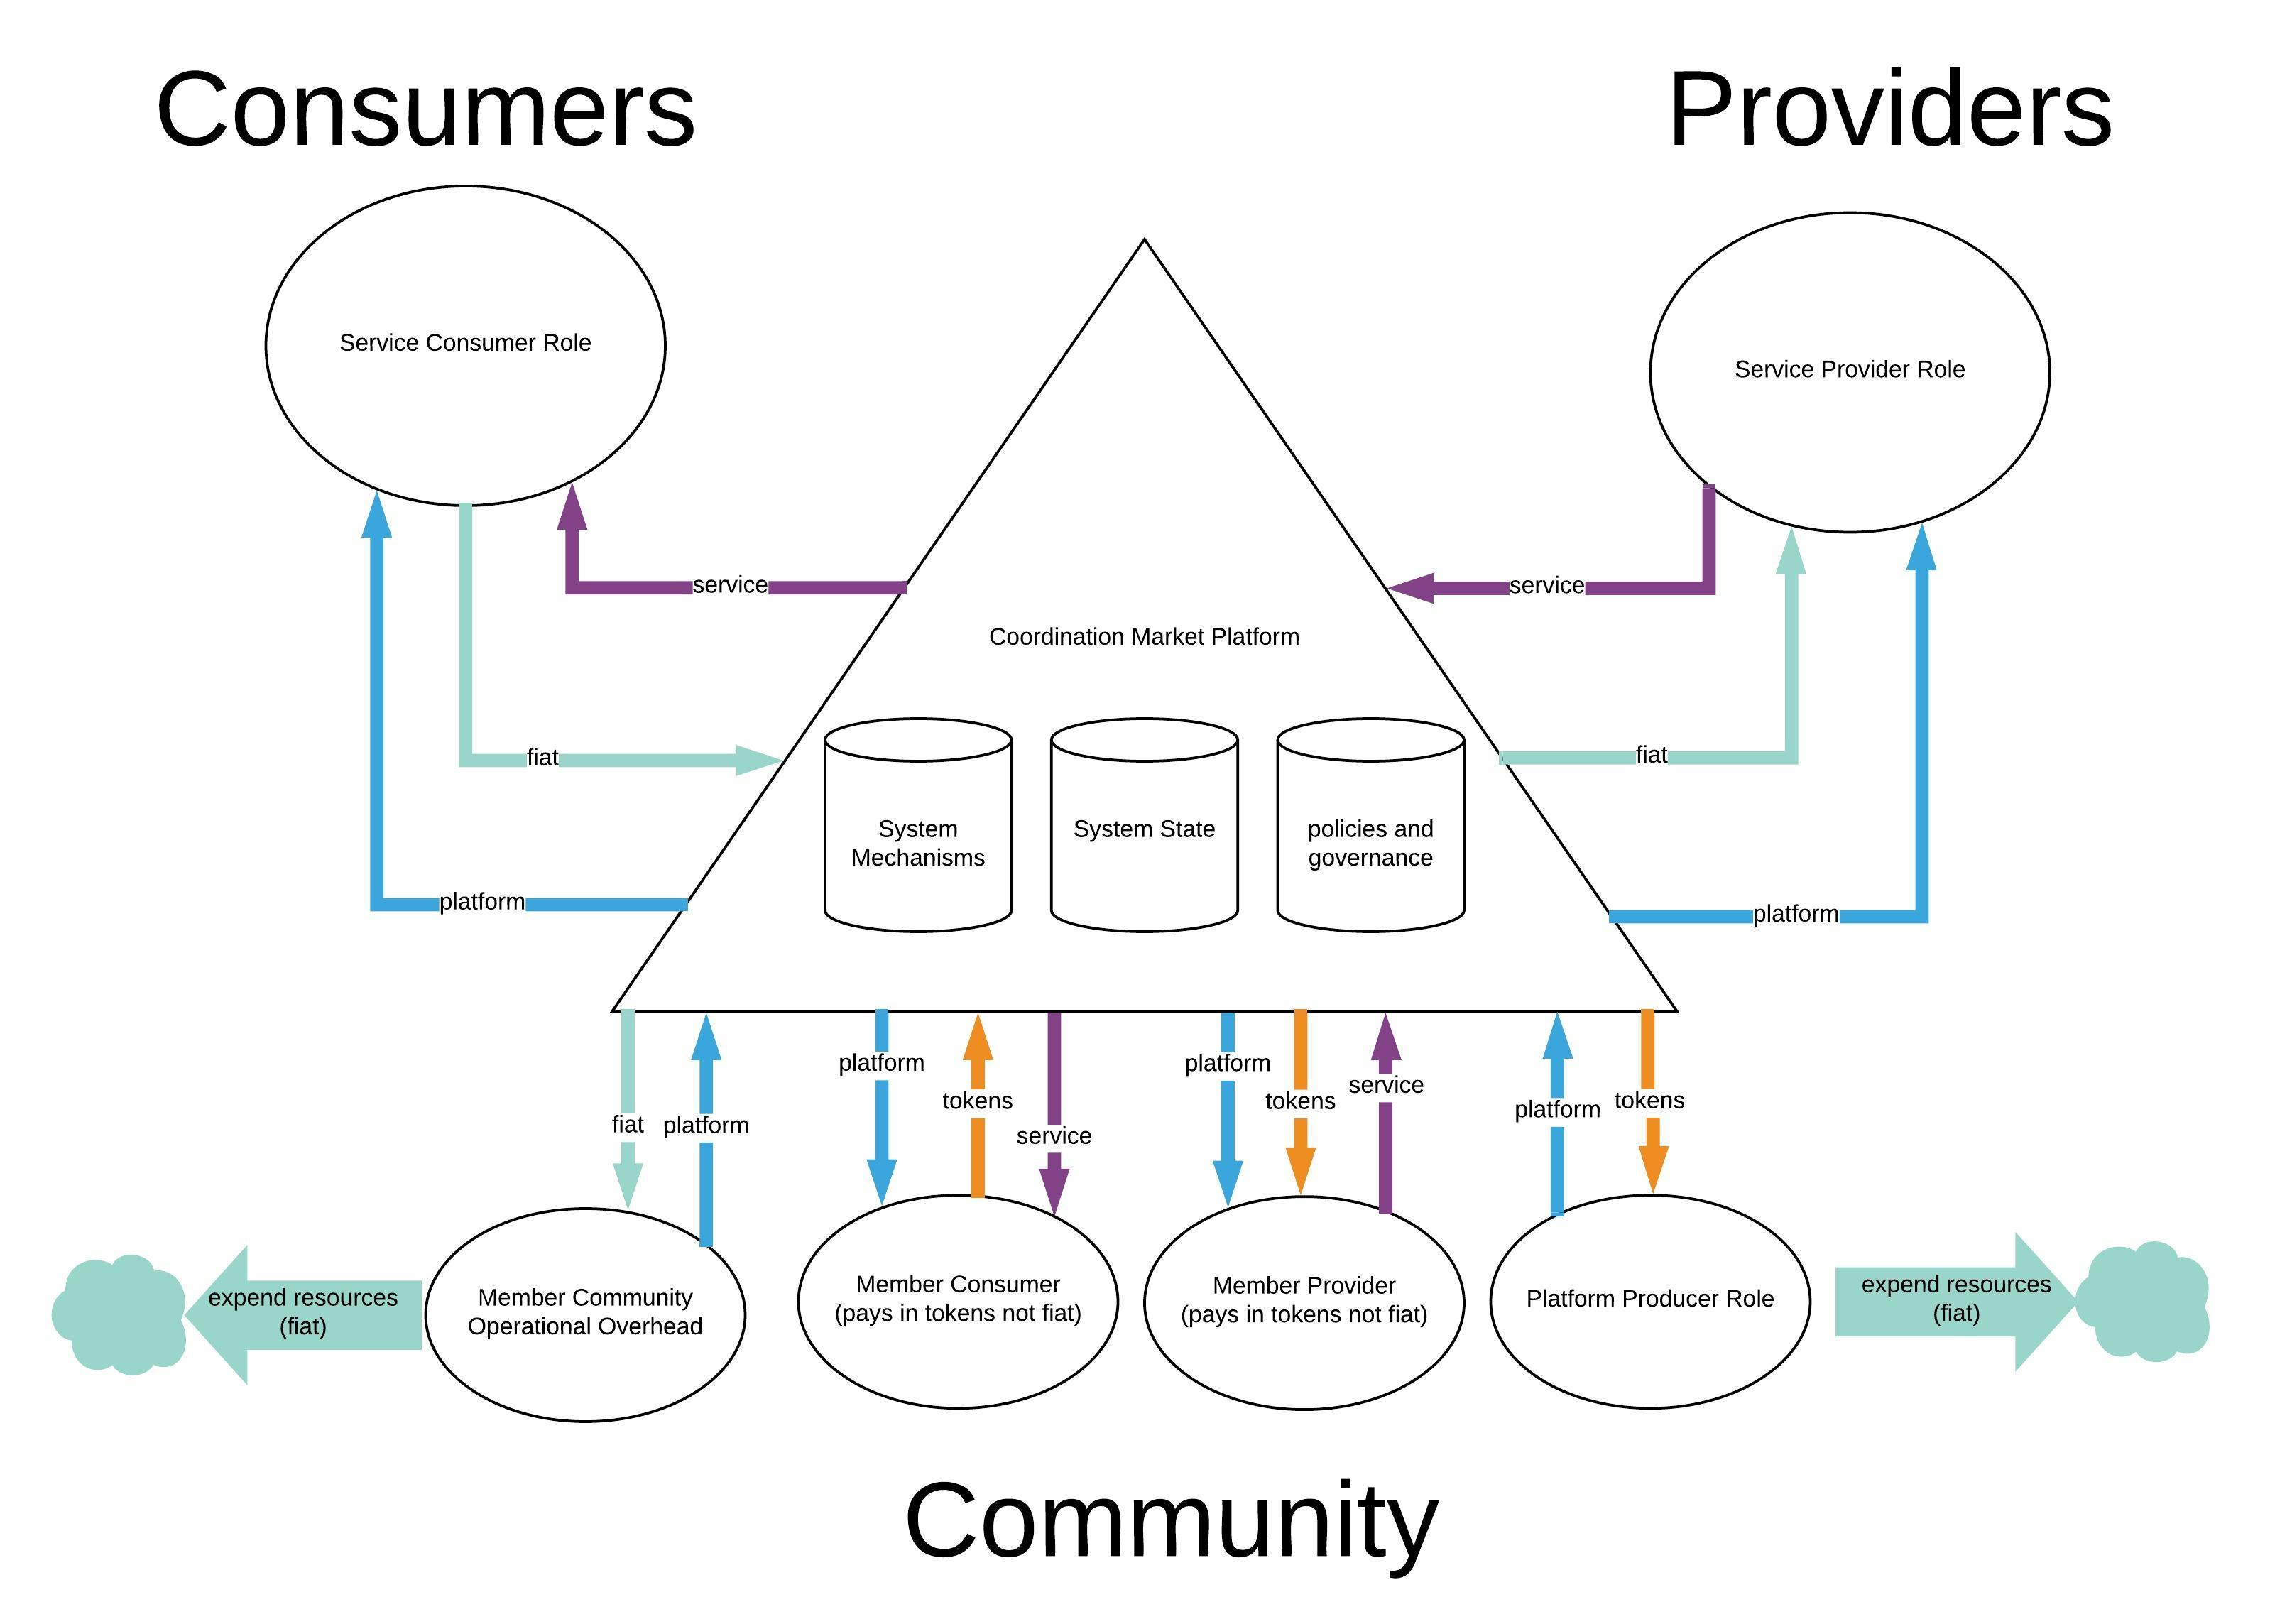

In [1]:
from IPython.display import Image
Image(filename='threesidedmarket.jpeg')

In [2]:
from decimal import Decimal
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
from tabulate import tabulate

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, proc_trigger, bound_norm_random, \
    ep_time_step
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor

In [3]:
#map for of differential game model configuration

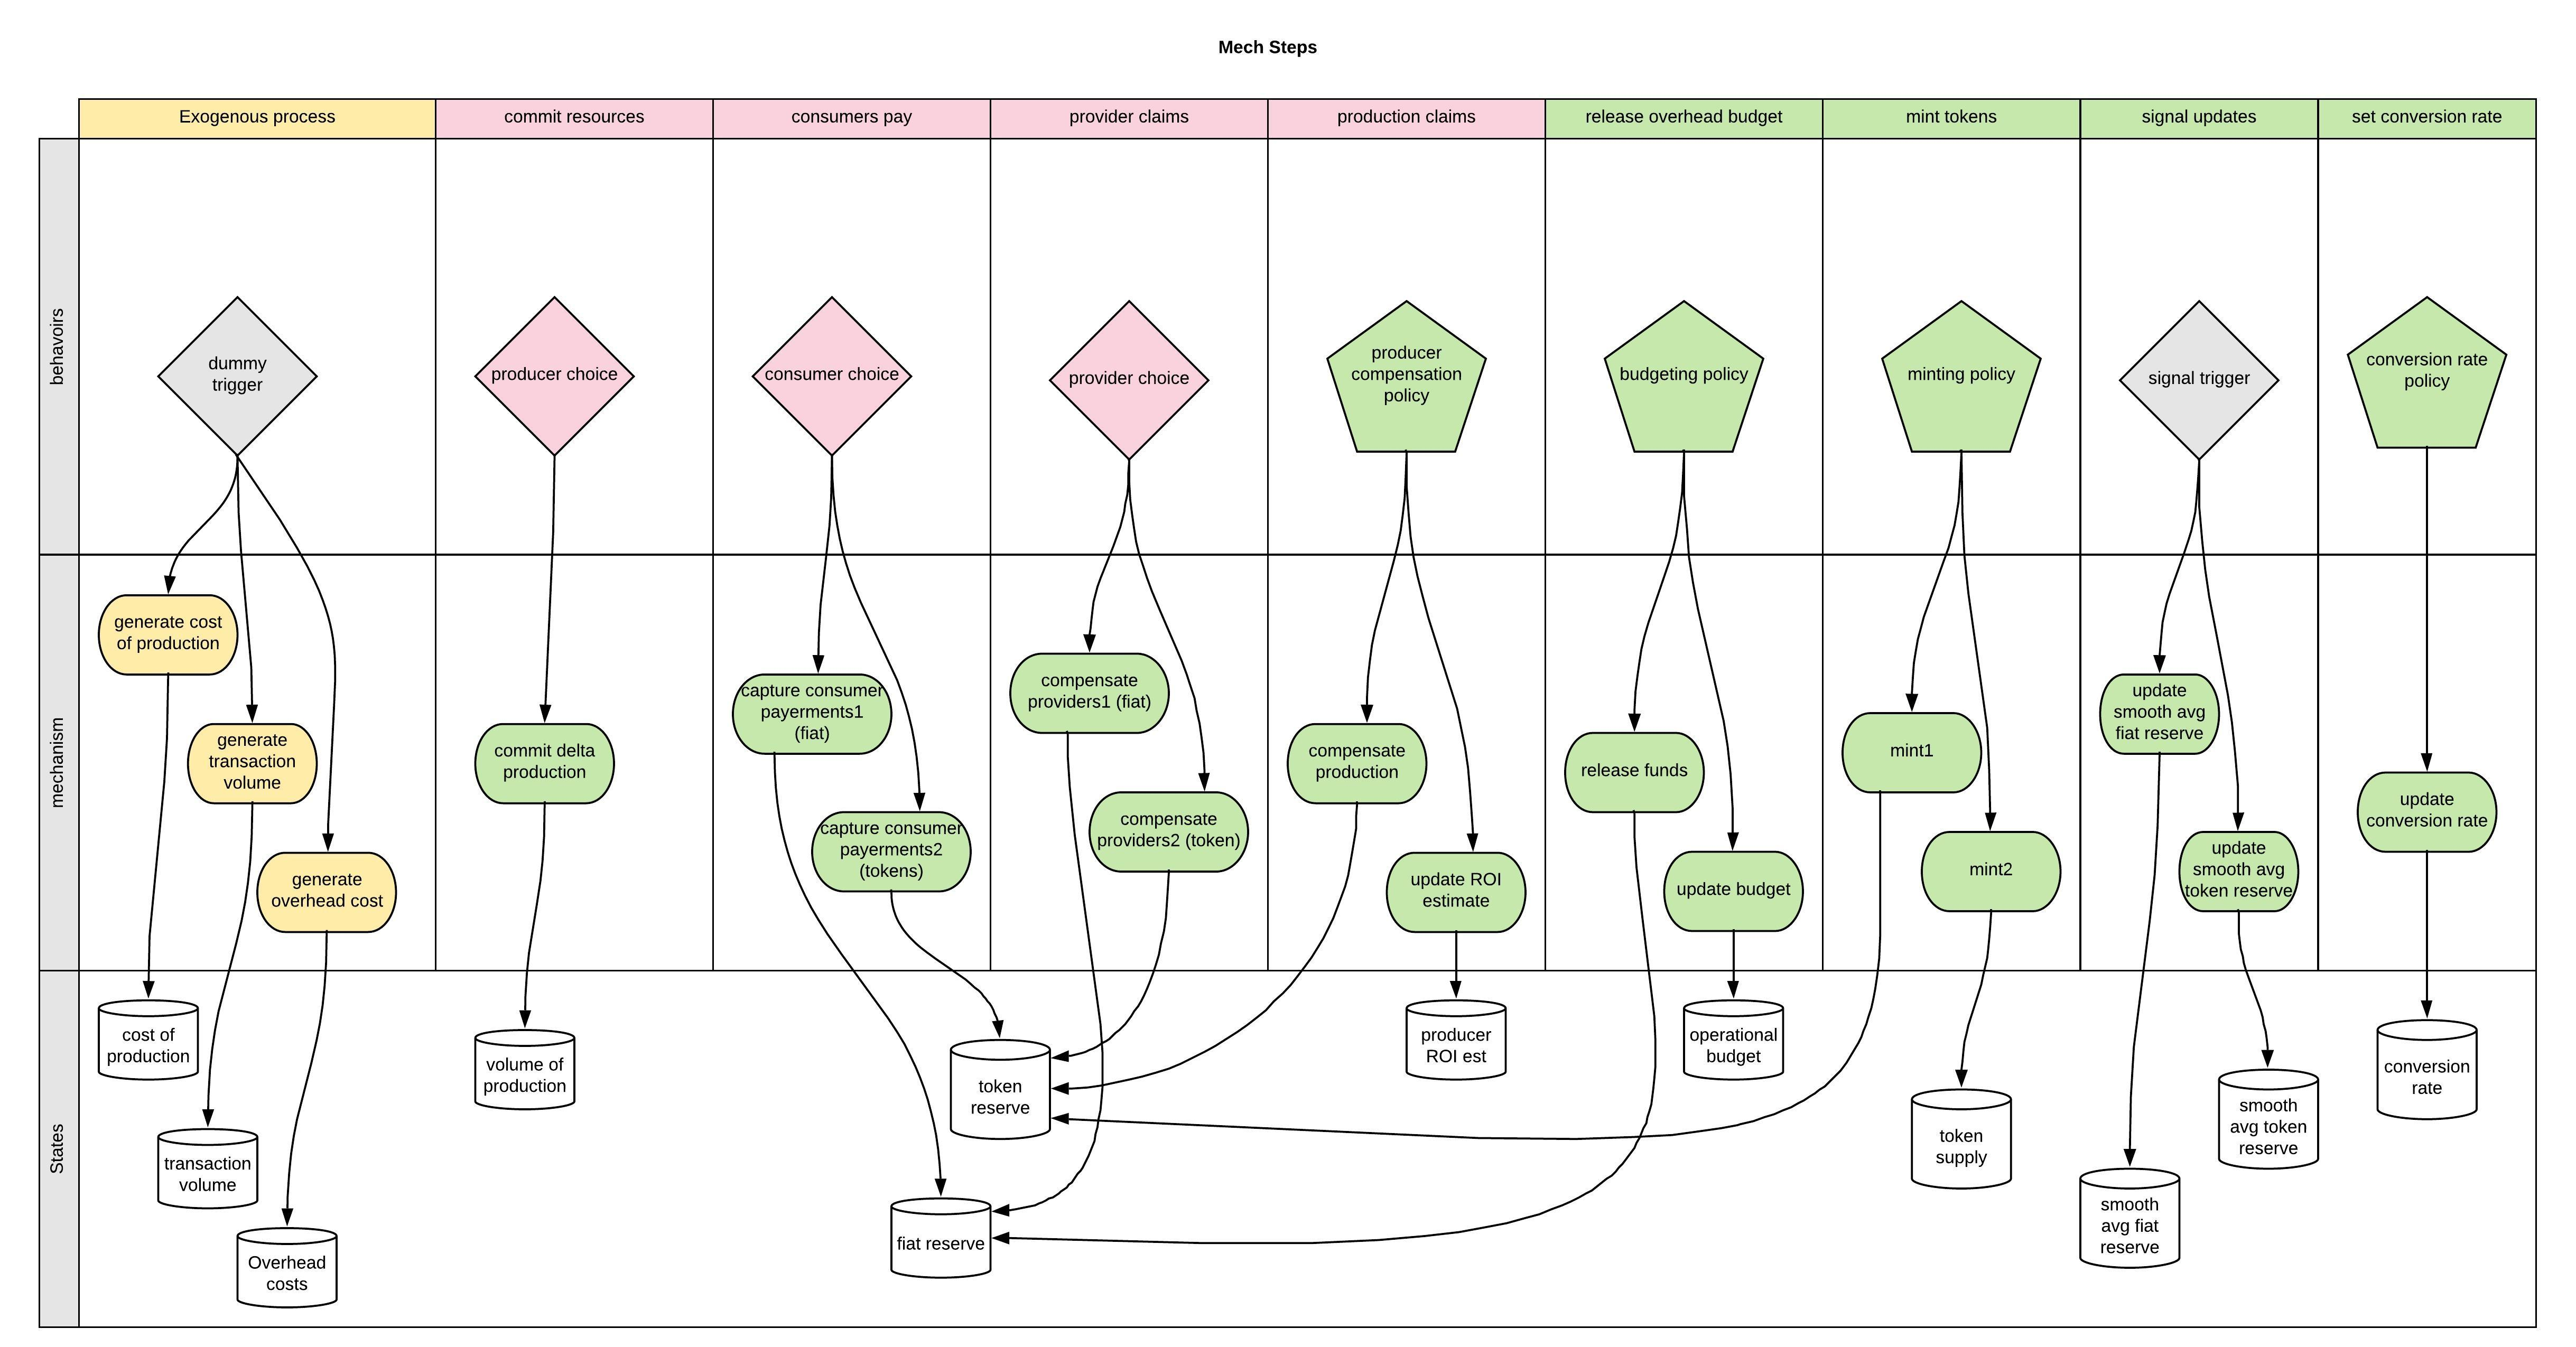

In [4]:
from IPython.display import Image
Image(filename='3SM-mechsteps.jpeg')

In [5]:
# Define the experiment
sim_config = {
    'N': 1, #number of repeated experiments
    'T': range(104) #number of discrete iterations in each experiement
}

In [6]:
#define the time deltas for the discrete increments in the model
ts_format = '%Y-%m-%d'
#
t_delta = timedelta(days=7)
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

exogenous_states = exo_update_per_ts(
    {
    'timestamp': time_model
    }
)

In [7]:
#define generator processes that characterize the world outside the system
#in future versions ingest data and fit stochastic process models
#then draw different realizations of those stochastic process models for Monte Carlo Sims

In [8]:
eta = .075
def tx_volume_generator(step, sL, s, _input):
    y = 'tx_volume'
    x = s['tx_volume']*(1+eta*np.random.rand())
    return (y, x)

In [9]:
alpha = .9
beta = 1.0
def cost_of_production_generator(step, sL, s, _input):
    y = 'cost_of_production'
    x = alpha*s['cost_of_production']+beta*np.random.rand()
    return (y, x)

In [10]:
#log quadratic overhead model; parameters
flat = 500
a = 1000.0
b = 100.0
c = 1.0
d = 1.0
def overhead_cost_generator(step, sL, s, _input):
    #unit fiat
    y = 'overhead_cost'
    q = a+b*s['tx_volume']+c*s['volume_of_production']+d*s['tx_volume']*s['volume_of_production']
    x = flat+np.log(q)
    return (y, x)

In [11]:
#State Variables ~ declare initial conditions

In [12]:
seed = {}
env_processes = {}
initial_condition = {
    'fiat_reserve': float(25000),#unit: fiat
    'overhead_cost': float(500), #unit: fiat
    'operational_budget': float(25000), #unit: fiat
    'token_reserve': float(25000),#unit: tok
    'token_supply': float(25000),#unit: tok
    'tx_volume': float(1000), #unit: fiat
    #'txo_fiat': float(1000), #unit: fiat
    #'txo_token': float(1000), #unit: tok
    #'txi_fiat': float(1000), #unit: fiat
    #'txi_token': float(1000), #unit: tok
    'conversion_rate': float(1), #unit: tok/fiat
    'cost_of_production': float(10), #unit: fiat/labor
    'volume_of_production': float(20), #unit: labor
    'producer_roi_estimate': float(1.1), #unitless //signal for informing policies
    'smooth_avg_fiat_reserve': float(25000), #unit: fiat //signal for informing policies
    'smooth_avg_token_reserve': float(25000), #unit: token //signal for informing policies
    'timestamp': '2019-01-01'
}

In [13]:
#Behavoirs (two types: controlled and uncontrolled)
#user behavoir is uncontrolled (estimated or modeled),
#governance policies are controlled (enforced)

In [14]:
#governance decision ~ system policy for token/fiat unit of value conversion
#static policy
conversion_rate_gain=1#

def conversion_policy(step, sL, s):
    ncr = conversion_rate_gain*s['smooth_avg_token_reserve']/s['smooth_avg_fiat_reserve']
    return {'new_conversion_rate': ncr}

In [15]:
#governance decision ~ determines the conditions or schedule of new tokens minted

final_supply = 1000000.0 #1M #unit: tokens
release_rate = .01 #percent of remaining

def minting_policy(step, sL, s):
    mint =  (final_supply-s['token_supply'])*release_rate
    return {'mint': mint}

In [16]:
#these are uncontrollerd choices of users in the provider consumer

def consumer_choice(step, sL, s):
    #fiat paid by consumers
    #note: balance of consumption vol covered in tokens (computed later)
    
    #simple heuristic ~ the fraction of token payment is proportion to free supply share
    free_supply = s['token_supply']-s['token_reserve']
    share_of_free_supply = free_supply/ s['token_supply']
    
    txi_fiat= (1.0-share_of_free_supply)*s['tx_volume']
    return {'txi_fiat': txi_fiat}

In [17]:
#these are uncontrollerd choices of users in the provider role

#simple heuristic ~ convex combination of 2 policies; parameterized by theta
#part1: fixed base rate ~ theta percent of service providers ALWAYS use fiat
theta = .6
#part2: remaining fraction is determined by the size of the platform community "economy"
#recall that both of the below states have 'fiat' as their unit, ratio is unitless
#parameter gamma is a tuning gain
gamma = .1
#simplifying math note:
#production_consumption_ratio = s['volume_of_production']*s['cost_of_production']/s['tx_volume']  
#production_consumption_ratio * s['tx_volume'] = s['volume_of_production']*s['cost_of_production']

def provider_choice(step, sL, s):
    #fiat claimed by providers
    #note: balance of provided vol covered in tokens (computed later)
    txo_fiat = theta*s['tx_volume']+ (1-theta)*gamma*s['volume_of_production']*s['cost_of_production']
    return {'txo_fiat': txo_fiat}

In [18]:
#these are uncontrollerd choices of users in the producer role

#estimatable parameters
roi_threshold = .2 
attrition_rate = .5
roi_gain = .025

def producer_choice(step, sL, s):
    #ROI heuristic
    # add or remove resources based on deviation from threshold
    if s['producer_roi_estimate'] < 0:
        delta_labor = s['volume_of_production']*(attrition_rate-1.0)
    else:
        ratio = s['producer_roi_estimate']/roi_threshold
        delta_labor = roi_gain*s['volume_of_production']*(ratio-1.0)
    
    return {'delta_labor': delta_labor}

In [19]:
#governance decision ~ system policy for compensating producers
#consider transaction volume, labor committed and token reserve and supply to determine payout

#this function is a parameter of this policy which determines diminishing value of more labor
base_value = 1000.0

def marginal_utility_function(x):
    #this is how much the platform value a total amount of production (in fiat)
    return base_value+np.sqrt(x)

def producer_compensation_policy(step, sL, s):
    tokens_paid = s['conversion_rate']*marginal_utility_function(s['volume_of_production'])
    return {'tokens_paid': tokens_paid}

In [20]:
#governance decision ~ system policy for budgeting to cover overhead costs

buffer_runway = 3.0
reserve_threshold = .25
min_budget_release = .03

def budgeting_policy(step, sL, s):
    #define an estimate of future overhead
    proj_overhead = s['overhead_cost'] #simple naive 
    
    #simple threshold based conditional logic
    if s['operational_budget']< buffer_runway*proj_overhead:
        target_release = buffer_runway*proj_overhead-s['operational_budget']
        if  s['fiat_reserve']-target_release > reserve_threshold*s['fiat_reserve']:
            budget_released =  target_release
        else:
            budget_released = (1.0-reserve_threshold)*s['fiat_reserve']
    else:
        budget_released = min_budget_release*s['fiat_reserve']
    
    return {'budget_released': budget_released}

In [21]:
#behavoirs used to trigger mechanisms with no explicit input

#tiggers environment
def dummy_behavior(step, sL, s):
    return {'value': 0}

#triggers smooth weighted averages
def signal_trigger(step, sL, s):
    return {'value': 0}

In [22]:
#Mechanisms

In [23]:
def update_conversion_rate(step, sL, s, _input):
    y = 'conversion_rate'
    x = _input['new_conversion_rate']
    return (y, x)

In [24]:
#smooth averaging signals
#forgetting rate parameter
rho = .1 #1 means you forget all past times, must be >0 

def update_smooth_avg_fiat_reserve(step, sL, s, _input):
    y = 'smooth_avg_fiat_reserve'
    x = s['fiat_reserve']*rho+s['smooth_avg_fiat_reserve']*(1-rho)
    return (y, x)

def update_smooth_avg_token_reserve(step, sL, s, _input):
    y = 'smooth_avg_token_reserve'
    x = s['token_reserve']*rho+s['smooth_avg_token_reserve']*(1-rho)
    return (y, x)

In [25]:
#minting process mints into the reserve
def mint1(step, sL, s, _input):
    y = 'token_supply'
    x = s['token_supply'] + _input['mint']
    return (y, x)

def mint2(step, sL, s, _input):
    y = 'token_reserve'
    x = s['token_reserve'] + _input['mint']
    return (y, x)

In [26]:
def commit_delta_production(step, sL, s, _input):
    y = 'volume_of_production'
    x = s['volume_of_production']+_input['delta_labor']
    return (y, x)

def compensate_production(step, sL, s, _input):
    y = 'token_reserve'
    x = s['token_reserve']-_input['tokens_paid']
    return (y, x)

#forgetting rate
rho2 = rho #same as for the other smoothed averages
def update_producer_roi_estimate(step, sL, s, _input):
    revenue = _input['tokens_paid']/s['conversion_rate']
    cost = s['cost_of_production']*s['volume_of_production']
    spot_ROI_estimate =   (revenue-cost)/cost
    y = 'producer_roi_estimate'
    x = rho2*spot_ROI_estimate + s['producer_roi_estimate']*(1.0-rho2)
    return (y, x)

In [27]:
conversion_fee = .03

def capture_consumer_payments1(step, sL, s, _input):
    #fiat inbound
    y = 'fiat_reserve'
    x = s['fiat_reserve']+_input['txi_fiat']
    return (y, x)

def capture_consumer_payments2(step, sL, s, _input):
    #tokens inbound
    y = 'token_reserve'
    fiat_eq = s['tx_volume']-_input['txi_fiat']
    x = s['token_reserve']+s['conversion_rate']*fiat_eq*(1.0+conversion_fee)
    return (y, x)

platform_fee = 0.075

def compensate_providers1(step, sL, s, _input):
    #fiat outbound
    y = 'fiat_reserve'
    x = s['fiat_reserve']-_input['txo_fiat']*(1.0-platform_fee)
    return (y, x)

def compensate_providers2(step, sL, s, _input):
    #tokens outbound
    y = 'token_reserve'
    fiat_eq = s['tx_volume']-_input['txo_fiat']
    x = s['token_reserve']-s['conversion_rate']*fiat_eq*(1.0-platform_fee-conversion_fee)
    return (y, x)

In [28]:
def release_funds(step, sL, s, _input):
    #tokens outbound
    y = 'fiat_reserve'
    x = s['fiat_reserve'] - _input['budget_released']
    return (y, x)

def update_budget(step, sL, s, _input):
    #tokens outbound
    y = 'operational_budget'
    x = s['operational_budget'] + _input['budget_released']
    return (y, x)

In [29]:
#build mechanism dictionary to "wire up the circuit"
mechanisms = {
    #mechstep 0
    'evolve': 
    {
        'behaviors': 
        {
            'dummy': dummy_behavior
        },
        'states':
        {
            'cost_of_production': cost_of_production_generator,
            'tx_volume': tx_volume_generator,
            'overhead_cost': overhead_cost_generator
         }      
    },
    
    #mechstep 1
    'producers_act': 
    {
        'behaviors': 
        {
            'action': producer_choice
        },
        'states': 
        {
            'volume_of_production': commit_delta_production
        }
    },
    
    #mechstep 2
    'consumers_act': 
    {
        'behaviors': 
        {
            'action': consumer_choice
        },
        'states': 
        {
            'fiat_reserve': capture_consumer_payments1,
            'token_reserve': capture_consumer_payments2
        }
    },
    
    #mechstep 3
    'providers_act': 
    {
        'behaviors': 
        {
            'action': provider_choice
        },
        'states': 
        {
            'fiat_reserve': compensate_providers1,
            'token_reserve': compensate_providers2
        }
    },
    
    #mechstep 4 #governance category policy
    'pay_producers': 
    {
        'behaviors': 
        {
            'action': producer_compensation_policy
        },
        'states': 
        {
            'token_reserve': compensate_production,
            'producer_roi_estimate': update_producer_roi_estimate
        }
     },
    
    #mechstep 5 #governance category policy
    'budgeting': 
    {
        'behaviors': 
        {
            'action': budgeting_policy
        },
        'states': 
        {
            'fiat_reserve': release_funds,
            'operational_budget': update_budget
        }
    },
    
    #mechstep 6 #governance category policy
    'minting': 
    {
        'behaviors': 
        {
            'action': minting_policy
        },
        'states': 
        {
            'token_reserve': mint1,
            'token_supply': mint2
        }
    },
        
    #mechstep 7 #simple signals computations
    'signal_updates': 
    {
        'behaviors': 
            {
            'action': signal_trigger
        },
        'states': 
        {
            'smooth_avg_fiat_reserve': update_smooth_avg_fiat_reserve,
            'smooth_avg_token_reserve':update_smooth_avg_token_reserve
        }
    },
            
    #mechstep 8 #governance category policy
    'price_controller': 
    {
        'behaviors': 
        {
            'action': conversion_policy
        },
        'states': 
        {
            'conversion_rate': update_conversion_rate
        }
    }   
}

In [30]:
# def widget_handler(beta=float(0.05), gamma=float(0.20),
#                    subscription_fee=float(1.0), 
#                    incentive_cost=float(10.0), 
#                    stickiness_cost=float(5.0)):
#     initial_condition['beta'] = beta
#     initial_condition['gamma'] = gamma
#     subscription_fee = subscription_fee
#     incentive_cost = incentive_cost
#     stickiness_cost = stickiness_cost
    
#     config = Configuration(
#             sim_config=sim_config,
#             state_dict=initial_condition,
#             seed=seed,
#             exogenous_states=exogenous_states,
#             env_processes=env_processes,
#             mechanisms=mechanisms)

#     exec_mode = ExecutionMode()
#     exec_context = ExecutionContext(exec_mode.single_proc)
#     executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
#     raw_result, tensor = executor.main()
#     df = pd.DataFrame(raw_result)
#     df['timestamp'] = pd.to_datetime(df['timestamp'], format=ts_format)
    
#     fig = plt.figure(figsize=(7, 14))
    
#     sir = fig.add_subplot(3, 1, 1)
#     sir.plot('timestamp', 'Ps', data=df, marker='', color='C0', linewidth=2)
#     sir.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
#     sir.plot('timestamp', 'Pr', data=df, marker='', color='green', linewidth=2)
#     sir.legend()
    
#     beta_gamma = fig.add_subplot(3, 1, 2)
#     beta_gamma.plot('timestamp', 'beta', data=df, marker='', color='C0', linewidth=2)
#     beta_gamma.plot('timestamp', 'gamma', data=df, marker='', color='orange', linewidth=2)
#     beta_gamma.legend()
    
#     budget_pi = fig.add_subplot(3, 1, 3)
#     budget_pi.plot('timestamp', 'Budget', data=df, marker='', color='C0', linewidth=2)
#     budget_pi.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
#     budget_pi.legend()
    
#     plt.show()
    
# sliders = interact_manual(widget_handler, 
#                 beta=(0, 1, 0.01),
#                 gamma=(0, 1, 0.01),
#                 subscription_fee=(0, 10, 0.1),
#                 incentive_cost=(0, 20, 0.5),
#                 stickiness_cost=(0, 20, 0.5)
#                )
# sliders

In [31]:
config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main()
df = pd.DataFrame(raw_result)

single_proc: [<SimCAD.configuration.Configuration object at 0x11911e0b8>]


In [32]:
# df.plot('timestamp', ['Ps','Pi', 'Pr'])
# df.plot('timestamp', ['beta', 'gamma'])
# df.plot('timestamp', ['Budget', 'Pi'])
# df[['Ps','Pi', 'Pr']].describe()

In [33]:
df.head()

conversion_rate  cost_of_production  fiat_reserve  mech_step  \
0              1.0            10.00000  25000.000000          0   
1              1.0             9.60629  25000.000000          1   
2              1.0             9.60629  25000.000000          2   
3              1.0             9.60629  26070.613127          3   
4              1.0             9.60629  25468.514463          4   

   operational_budget  overhead_cost  producer_roi_estimate  run  \
0             25000.0     500.000000                    1.1    1   
1             25000.0     511.703711                    1.1    1   
2             25000.0     511.703711                    1.1    1   
3             25000.0     511.703711                    1.1    1   
4             25000.0     511.703711                    1.1    1   

   smooth_avg_fiat_reserve  smooth_avg_token_reserve  time_step   timestamp  \
0                  25000.0                   25000.0          0  2019-01-01   
1                  25000.0                   25000.0          1  2019-01-08   
2                  25000.0                   25000.0          1  2019-01-08   
3                  25000.0                   25000.0          1  2019-01-08   
4                  25000.0                   25000.0          1  2019-01-08   

   token_reserve  token_supply    tx_volume  volume_of_production  
0   25000.000000       25000.0  1000.000000                 20.00  
1   25000.000000       25000.0  1070.613127                 20.00  
2   25000.000000       25000.0  1070.613127                 22.25  
3   25000.000000       25000.0  1070.613127                 22.25  
4   24624.372391       25000.0  1070.613127                 22.25

In [34]:
rdf=df[df.mech_step==9].copy()
rdf.head()

conversion_rate  cost_of_production  fiat_reserve  mech_step  \
9          1.034702            9.606290  24704.459029          9   
18         1.100521            9.376439  24387.122926          9   
27         1.194015            8.556163  24078.990778          9   
36         1.311996            8.441051  23787.933002          9   
45         1.451572            7.968585  23509.132739          9   

    operational_budget  overhead_cost  producer_roi_estimate  run  \
9         25764.055434     511.703711               1.360065    1   
18        26518.296349     511.789835               1.544795    1   
27        27263.007404     511.842447               1.685196    1   
36        27998.716672     511.933639               1.754430    1   
45        28725.803252     512.039533               1.778724    1   

    smooth_avg_fiat_reserve  smooth_avg_token_reserve  time_step   timestamp  \
9              24970.445903              25836.965540          1  2019-01-08   
18             24912.113605              27416.292133          2  2019-01-15   
27             24828.801323              29645.953569          3  2019-01-22   
36             24724.714491              32438.717331          4  2019-01-29   
45             24603.156315              35713.244830          5  2019-02-05   

    token_reserve  token_supply    tx_volume  volume_of_production  
9    33369.655400  34750.000000  1070.613127             22.250000  
18   41630.231465  44402.500000  1099.846197             25.476431  
27   49712.906496  53958.475000  1165.814731             29.759003  
36   57573.591189  63418.890250  1243.923179             35.283746  
45   65183.992318  72784.701347  1305.756929             42.139511

In [35]:
rdf.tail()

conversion_rate  cost_of_production  fiat_reserve  mech_step  \
900        17.246983            4.471451  31426.205808          9   
909        16.536117            4.674597  32992.574604          9   
918        15.858142            4.376216  34584.171484          9   
927        15.211750            4.764640  36271.010598          9   
936        14.588760            4.626827  38164.575141          9   

     operational_budget  overhead_cost  producer_roi_estimate  run  \
900        70640.458442     516.076055               0.336838    1   
909        71660.847347     516.139995               0.314978    1   
918        72730.460898     516.180719               0.301248    1   
927        73852.244731     516.206337               0.277948    1   
936        75032.592416     516.263750               0.259105    1   

     smooth_avg_fiat_reserve  smooth_avg_token_reserve  time_step   timestamp  \
900             21778.706319             375616.968473        100  2020-12-01   
909             22900.093148             378678.622275        101  2020-12-08   
918             24068.500981             381681.716027        102  2020-12-15   
927             25288.751943             384686.167380        103  2020-12-22   
936             26576.334263             387715.763169        104  2020-12-29   

     token_reserve   token_supply     tx_volume  volume_of_production  
900  403467.174511  643118.467259  35156.692021            190.704716  
909  406233.506489  646687.282586  36211.790984            193.966675  
918  408709.559796  650220.409760  36802.566095            196.754422  
927  411726.229564  653718.205663  38653.219841            199.244554  
936  414982.125266  657181.023606  41543.209511            201.185891

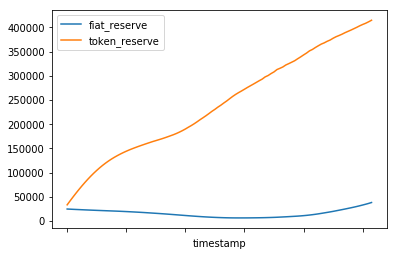

In [36]:
rdf.plot(x='timestamp', y = ["fiat_reserve", "token_reserve"])

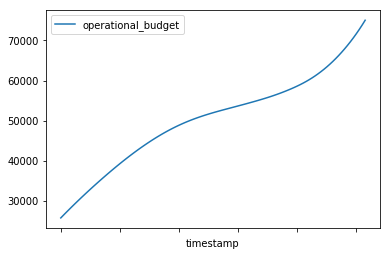

In [37]:
rdf.plot(x='timestamp', y = "operational_budget")

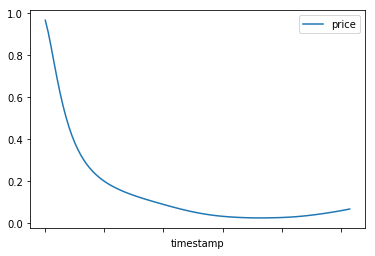

In [38]:
rdf["price"] = rdf.conversion_rate.apply(lambda r: 1/r)
rdf.plot(x='timestamp', y = "price")

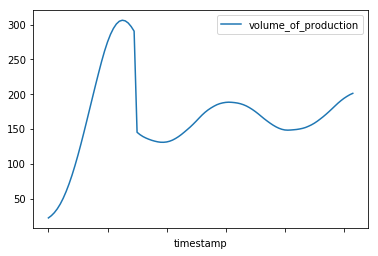

In [39]:
rdf.plot(x='timestamp', 
         y = "volume_of_production")

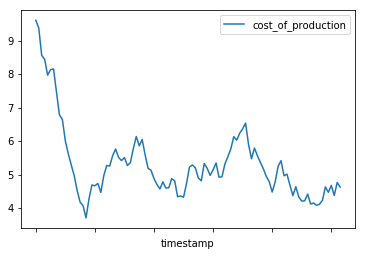

In [40]:
rdf.plot(x='timestamp', 
         y = "cost_of_production")

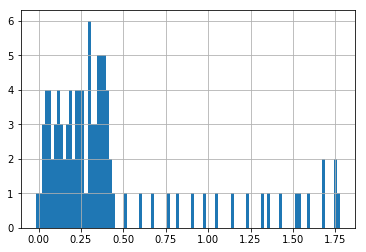

In [41]:
rdf.producer_roi_estimate.hist(bins=100)

In [42]:
pdf=df[df.mech_step==1].copy()
pdf.head(12)

conversion_rate  cost_of_production  fiat_reserve  mech_step  \
1           1.000000            9.606290  25000.000000          1   
10          1.034702            9.376439  24704.459029          1   
19          1.100521            8.556163  24387.122926          1   
28          1.194015            8.441051  24078.990778          1   
37          1.311996            7.968585  23787.933002          1   
46          1.451572            8.130411  23509.132739          1   
55          1.610184            8.153768  23231.705532          1   
64          1.785495            7.459641  22954.372820          1   
73          1.975161            6.782330  22691.386417          1   
82          2.177047            6.643686  22436.708566          1   
91          2.389261            6.003507  22183.730776          1   
100         2.609987            5.618266  21935.667582          1   

     operational_budget  overhead_cost  producer_roi_estimate  run  \
1          25000.000000     511.703711               1.100000    1   
10         25764.055434     511.789835               1.360065    1   
19         26518.296349     511.842447               1.544795    1   
28         27263.007404     511.933639               1.685196    1   
37         27998.716672     512.039533               1.754430    1   
46         28725.803252     512.136947               1.778724    1   
55         29444.309608     512.219048               1.746353    1   
64         30154.238665     512.304283               1.676996    1   
73         30856.034121     512.423659               1.598836    1   
82         31549.952943     512.535491               1.516518    1   
91         32236.047709     512.641401               1.420634    1   
100        32914.470418     512.753509               1.328236    1   

     smooth_avg_fiat_reserve  smooth_avg_token_reserve  time_step   timestamp  \
1               25000.000000              25000.000000          1  2019-01-08   
10              24970.445903              25836.965540          2  2019-01-15   
19              24912.113605              27416.292133          3  2019-01-22   
28              24828.801323              29645.953569          4  2019-01-29   
37              24724.714491              32438.717331          5  2019-02-05   
46              24603.156315              35713.244830          6  2019-02-12   
55              24466.011237              39394.776936          7  2019-02-19   
64              24314.847395              43414.049116          8  2019-02-26   
73              24152.501298              47705.069904          9  2019-03-05   
82              23980.922024              52207.587867         10  2019-03-12   
91              23801.202900              56867.286387         11  2019-03-19   
100             23614.649368              61633.937409         12  2019-03-26   

     token_reserve   token_supply    tx_volume  volume_of_production  
1     25000.000000   25000.000000  1070.613127             20.000000  
10    33369.655400   34750.000000  1099.846197             22.250000  
19    41630.231465   44402.500000  1165.814731             25.476431  
28    49712.906496   53958.475000  1243.923179             29.759003  
37    57573.591189   63418.890250  1305.756929             35.283746  
46    65183.992318   72784.701347  1339.676883             42.139511  
55    72528.565890   82056.854334  1370.584757             50.455342  
64    79587.498740   91236.285791  1444.884644             60.208063  
73    86324.256993  100323.922933  1506.829271             71.323948  
82    92730.249539  109320.683703  1558.804847             83.795261  
91    98804.573063  118227.476866  1622.079699             97.585007  
100  104533.796602  127045.202098  1685.736680            112.474450

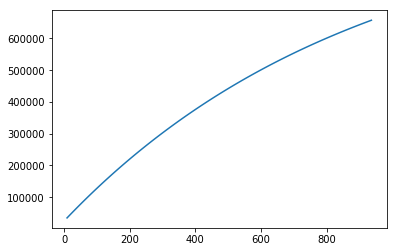

In [43]:
rdf.token_supply.plot()